In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_images(images, titles=None, cols=3):
    if titles is None:
        titles = ['Image ' + str(i + 1) for i in range(len(images))]

    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))

    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
def scale_down(image, resize_ratio):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # (5, 5) is the kernel size, and 0 is the standard deviation

    f_transform = fft2(blurred_image)
    f_transform = fftshift(f_transform)

    # 0 < ratio < 1
    new_h, new_w = int(image.shape[0] * resize_ratio), int(image.shape[1] * resize_ratio)
    center_h, center_w = f_transform.shape[0] // 2, f_transform.shape[1] // 2

    # crop the frequency spectrum
    cropped_transform = f_transform[center_h - new_h // 2:center_h + new_h // 2, 
                                    center_w - new_w // 2:center_w + new_w // 2]
    
    # after cropping, inverse fft
    downscaled_image = np.abs(ifft2(ifftshift(cropped_transform)))
    return downscaled_image

TEST

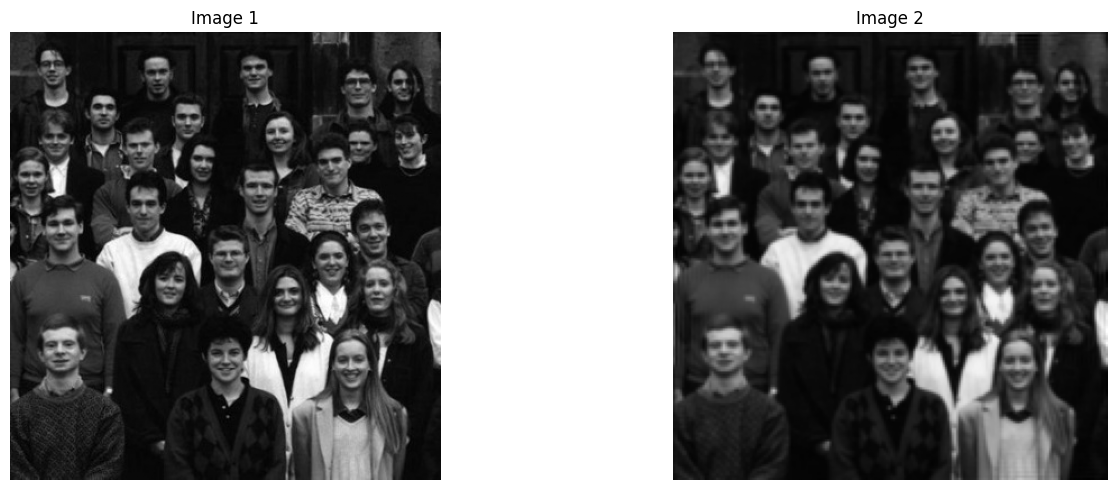

Original image shape: (399, 384)
Scaled image shape: (198, 192)


In [4]:
images = []
img = cv2.imread('students.jpg', cv2.IMREAD_GRAYSCALE)
scaled_img = scale_down(img, 0.5)

images.append(img)
images.append(scaled_img)
plot_images(images, cols=2)

print(f"Original image shape: {img.shape}")
print(f"Scaled image shape: {scaled_img.shape}")

In [5]:
def scale_up(image, resize_ratio):
    f_transform = fft2(image)
    f_transform = fftshift(f_transform)

    # ratio > 1
    new_h, new_w = int(image.shape[0] * resize_ratio), int(image.shape[1] * resize_ratio)
    center_h, center_w = new_h // 2, new_w // 2

    # define the wanted image size
    expanded_transform = np.zeros((new_h, new_w), dtype=complex)

    orig_h, orig_w = f_transform.shape
    orig_center_h, orig_center_w = orig_h // 2, orig_w // 2

    start_h = center_h - orig_center_h
    end_h = start_h + orig_h
    start_w = center_w - orig_center_w
    end_w = start_w + orig_w

    # copy the fourier spectrum to the scaled up image, from the center
    expanded_transform[start_h:end_h, start_w:end_w] = f_transform
    
    # shift back to 0,0 and inverse fft
    expanded_spectrum = ifftshift(expanded_transform)
    scaled_up_image = np.abs(ifft2(expanded_spectrum))
    
    return scaled_up_image

TEST

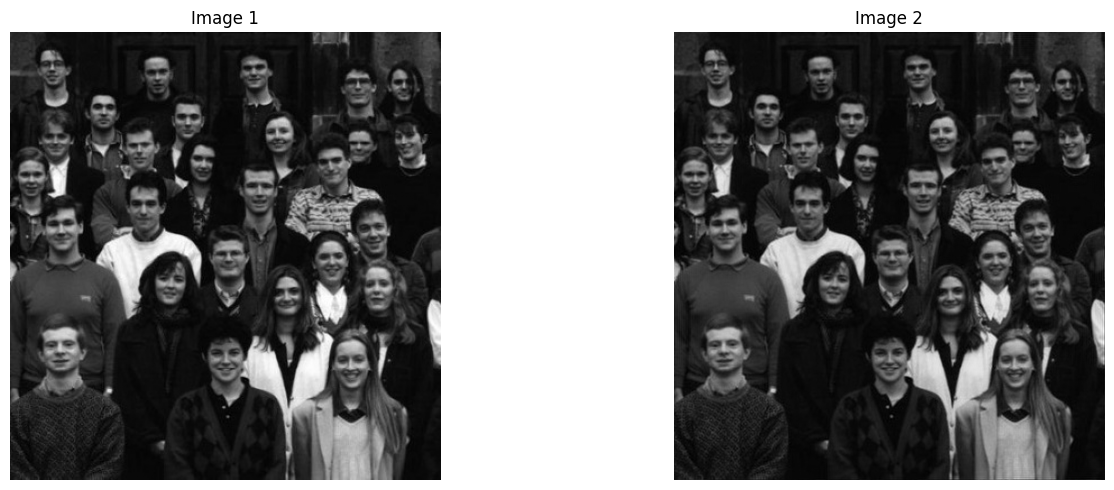

Original image shape: (399, 384)
Scaled image shape: (798, 768)


In [6]:
images = []
img = cv2.imread('students.jpg', cv2.IMREAD_GRAYSCALE)
scaled_img = scale_up(img, 2)

images.append(img)
images.append(scaled_img)
plot_images(images, cols=2)

print(f"Original image shape: {img.shape}")
print(f"Scaled image shape: {scaled_img.shape}")

In [7]:
def ncc_2d(image, pattern):
    windows = np.lib.stride_tricks.sliding_window_view(image, pattern.shape)

    window_means = np.mean(windows, axis=(-2, -1))
    pattern_mean = np.mean(pattern)

    numerator = np.sum((windows - window_means[..., None, None])
                       * (pattern - pattern_mean), axis=(-2, -1))
    
    # The denominator is essentially std sums of each window and pattern
    window_stds = np.std(windows, axis=(-2, -1))
    pattern_std = np.std(pattern)

    epsilon = 1e-6
    denominator = window_stds * pattern_std + epsilon


    ncc = np.zeros_like(denominator)
    valid_mask = denominator != epsilon                                # Mask for non-zero denominators
    ncc[valid_mask] = numerator[valid_mask] / denominator[valid_mask]  # Compute NCC only where denominator is not 0

    max_ncc = np.max(ncc)
    min_ncc = np.min(ncc)
    
    if max_ncc != min_ncc:  # Avoid division by zero if all values are identical
        ncc = 2 * (ncc - min_ncc) / (max_ncc - min_ncc) - 1  # Normalize to [-1, 1]

    return ncc

### <font color='aqua'>DON'T CHANGE THIS</font>

In [8]:
CURR_IMAGE = "students"

In [9]:
def display(image, pattern):
	
	plt.subplot(2, 3, 1)
	plt.title('Image')
	plt.imshow(image, cmap='gray')
		
	plt.subplot(2, 3, 3)
	plt.title('Pattern')
	plt.imshow(pattern, cmap='gray', aspect='equal')
	
	ncc = ncc_2d(image, pattern)
	
	plt.subplot(2, 3, 5)
	plt.title('Normalized Cross-Correlation Heatmap')
	plt.imshow(ncc ** 2, cmap='coolwarm', vmin=0, vmax=1, aspect='auto') 
	
	cbar = plt.colorbar()
	cbar.set_label('NCC Values')
		
	plt.show()

def draw_matches(image, matches, pattern_size):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	for point in matches:
		y, x = point
		top_left = (int(x - pattern_size[1]/2), int(y - pattern_size[0]/2))
		bottom_right = (int(x + pattern_size[1]/2), int(y + pattern_size[0]/2))
		cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 1)
	
	plt.imshow(image, cmap='gray')
	plt.show()
	
	cv2.imwrite(f"{CURR_IMAGE}_result.jpg", image)

### 

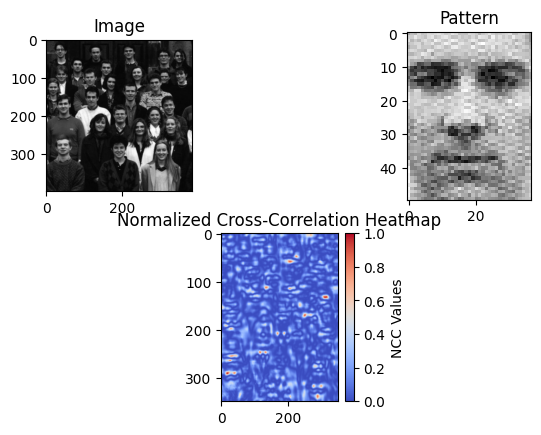

In [10]:
image = cv2.imread(f'{CURR_IMAGE}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

pattern = cv2.imread('template.jpg')
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

############# DEMO #############
display(image, pattern)

Students

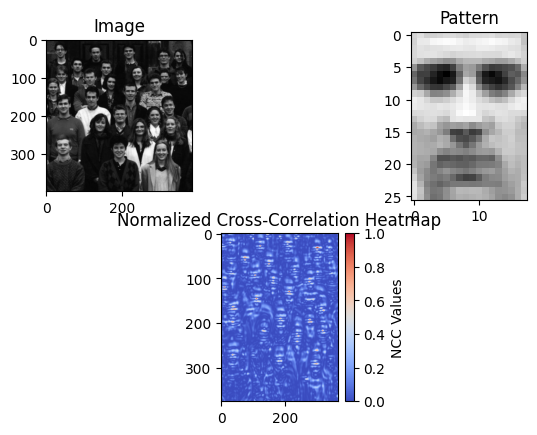

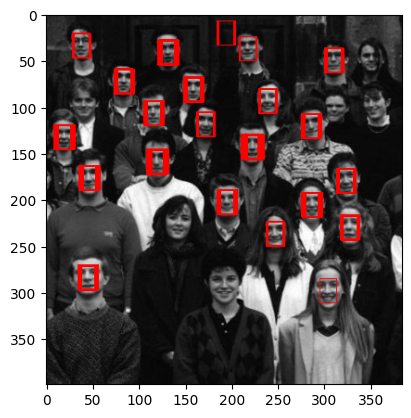

In [11]:
############# Students #############

image_scaled = image
pattern_scaled =  scale_down(pattern, 0.53)

display(image_scaled, pattern_scaled)

ncc = ncc_2d(image_scaled, pattern_scaled)
real_matches = np.argwhere(ncc > 0.7)

######### DONT CHANGE THE NEXT TWO LINES #########
real_matches[:,0] += pattern_scaled.shape[0] // 2			# if pattern was not scaled, replace this with "pattern"
real_matches[:,1] += pattern_scaled.shape[1] // 2			# if pattern was not scaled, replace this with "pattern"

# If you chose to scale the original image, make sure to scale back the matches in the inverse resize ratio.

draw_matches(image, real_matches, pattern_scaled.shape)	# if pattern was not scaled, replace this with "pattern"

Crew

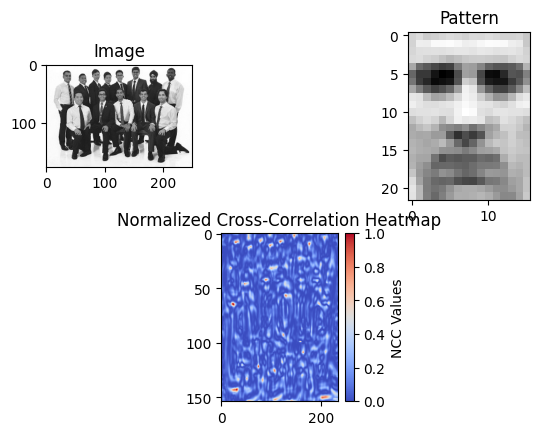

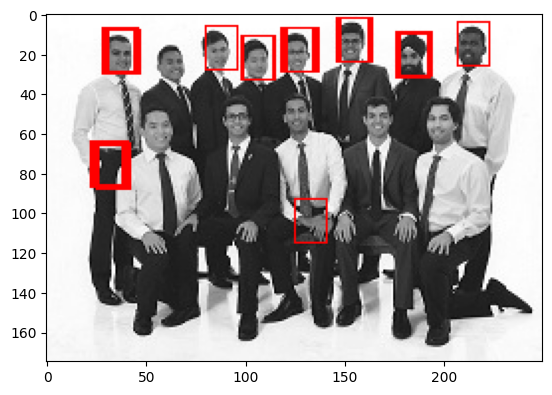

In [24]:
CURR_IMAGE = "thecrew"
image = cv2.imread(f'{CURR_IMAGE}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_scaled = image
pattern_scaled =  scale_down(pattern, 0.45)

display(image_scaled, pattern_scaled)

ncc = ncc_2d(image_scaled, pattern_scaled)
real_matches = np.argwhere(ncc > 0.837)

######### DONT CHANGE THE NEXT TWO LINES #########
real_matches[:,0] += pattern_scaled.shape[0] // 2			# if pattern was not scaled, replace this with "pattern"
real_matches[:,1] += pattern_scaled.shape[1] // 2			# if pattern was not scaled, replace this with "pattern"

# If you chose to scale the original image, make sure to scale back the matches in the inverse resize ratio.

draw_matches(image, real_matches, pattern_scaled.shape)	# if pattern was not scaled, replace this with "pattern"